In [1]:
#importing Libraries required to run the model..
import os
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
if int(os.environ.get("MODERN_PANDAS_EPUB", 0)):
    import prep # noqa
from sklearn.metrics import mutual_info_score

pd.set_option('display.max_colwidth', -1)
pd.options.display.max_rows = 10
sns.set(style='ticks', context='talk')
# Read csv in a Spark
#Gender = pd.read_csv(GenderFilePath,sep='^') 
#Gender.info()

import re
import numpy as np
import pandas as pd
from pprint import pprint
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', -1)  # or 199
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import re
from urllib.parse import urlparse
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
import nltk
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from numpy import arange
from matplotlib import pyplot
from pandas import read_csv
from pandas import set_option
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

from sklearn.tree import DecisionTreeRegressor

In [ ]:
# Read csv in a Spark
GenderFilePath = "/usr/local/bin/Gender Prediction/Data/genderprediction.txt"

import pandas as pd
Gender = pd.read_csv(GenderFilePath, delimiter='\t', names=["UserId", "Gender", "Age", "Language", "description", "long_description", "URL", "DateTime"])

Gender.head(1000)

In [3]:
#Copy the dataframe
df= Gender.copy()

In [4]:
# Load Stop words
    nltk.download('stopwords')
    from nltk.corpus import stopwords
    stop_words = stopwords.words('english')
    stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
def Datapreprocess(df):
    
    # Filling long_description missing values with description column..
    df['long_description'].fillna(df['description'])
#droping missing values....
    del df['description']
    df.dropna(subset=['UserId'],inplace=True)
    df.dropna(subset=['Gender'],inplace=True)
    df.dropna(subset=['long_description'],inplace=True)
    df.dropna(subset=['DateTime'],inplace=True)

    df['Create Time'] = pd.to_datetime(df['DateTime'])

    # Category Based Features 
    df['URL'].str.strip()
    df['domain'] = df['URL'].str.split('//').str[-1].str.split('/').str[0]
    df['Count'] = df['URL'].str.split('//').str[-1].str.split('/').str.len()
    mask = df['Count'] > 2

    df['Categ'] = np.where(mask,df['URL'].str.split('//').str[-1].str.split('/').str[1], 'No Category')
    df['Subcateg'] = np.where(mask, df['URL'].str.split('//').str[-1].str.split('/').str[2], 'No Subcategory')

    df['Categ'] = df.Categ.astype('category')
    df['Subcateg']= df.Subcateg.astype('category')
    df['domain'] = df.domain.astype('category')
    df1=df[mask]
    # Time n Squential Based
    df1['Gender'] = df1['Gender'].astype('category')
    df1["Create Time"]= pd.to_datetime(df1['Create Time'])
    df1['time_hour'] = df1['Create Time'].apply(lambda x: x.hour)
    df1.Gender.replace(['M', 'F'], [0, 1], inplace=True)

    df2 = df1[df1['long_description'].notna()]
    def sent_to_words(sentences):
        for sent in sentences:
            sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
            sent = re.sub('\s+', ' ', sent)  # remove newline chars
            sent = re.sub("\'", "", sent)  # remove single quotes
            sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
            yield(sent)  
    # Convert to list
    data_ld = df2.long_description.values.tolist()

    data_words = list(sent_to_words(data_ld))
     #Define functions for stopwords, bigrams, trigrams and lemmatization
    def remove_stopwords(texts):
        return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

    def make_bigrams(texts):
        return [bigram_mod[doc] for doc in texts]

    def make_trigrams(texts):
        return [trigram_mod[bigram_mod[doc]] for doc in texts]

    def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
        """https://spacy.io/api/annotation"""
        texts_out = []
        for sent in texts:
            doc = nlp(" ".join(sent)) 
            texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
        return texts_out

    # Build the bigram and trigram models
    bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
    trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

    # Faster way to get a sentence clubbed as a trigram/bigram
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    # Remove Stop Words
    data_words_nostops = remove_stopwords(data_words)

    # Form Bigrams
    data_words_bigrams = make_bigrams(data_words_nostops)

    # Initialize spacy 'en' model, keeping only tagger component (for efficiency)
    # python3 -m spacy download en
    nlp = spacy.load('en', disable=['parser', 'ner'])

    # Do lemmatization keeping only noun, adj, vb, adv
    data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
    # Create Dictionary
    id2word = corpora.Dictionary(data_lemmatized)

    # Create Corpus
    texts = data_lemmatized

    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]
    #For Gibbs sampling using MAllet package...
    mallet_path = '/usr/local/bin//mallet-2.0.8/bin/mallet' # update this path
    ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

    # Build LDA model
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=id2word,
                                               num_topics=20, 
                                               random_state=100,
                                               update_every=1,
                                               chunksize=100,
                                               passes=10,
                                               alpha='auto',
                                               per_word_topics=True)

    def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ld):
        # Init output
        sent_topics_df = pd.DataFrame()

        # Get main topic in each document
        for i, row in enumerate(ldamodel[corpus]):
            row = sorted(row, key=lambda x: (x[1]), reverse=True)
            # Get the Dominant topic, Perc Contribution and Keywords for each document
            for j, (topic_num, prop_topic) in enumerate(row):
                if j == 0:  # => dominant topic
                    wp = ldamodel.show_topic(topic_num)
                    topic_keywords = ", ".join([word for word, prop in wp])
                    sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
                else:
                    break
        sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

        # Add original text to the end of the output
        contents = pd.Series(texts)
        sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
        return(sent_topics_df)

    # Compute Coherence Score
    def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
        """
        Compute c_v coherence for various number of topics
    Parameters:
        ----------
        dictionary : Gensim dictionary
        corpus : Gensim corpus
        texts : List of input texts
        limit : Max num of topics
     Returns:
        -------
        model_list : List of LDA topic models
        coherence_values : Coherence values corresponding to the LDA model with respective number of topics
        """
        coherence_values = []
        model_list = []
        for num_topics in range(start, limit, step):
            model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
            model_list.append(model)
            coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
            coherence_values.append(coherencemodel.get_coherence())

        return model_list, coherence_values
    coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    coherence_ldamallet = coherence_model_ldamallet.get_coherence()
    model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)
    # Select the model and print the topics
    optimal_model = model_list[3]
    model_topics = optimal_model.show_topics(formatted=False)

    df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data_ld )

    # Format
    df_dominant_topic = df_topic_sents_keywords.reset_index()
    df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'long_description']

    df3 = pd.merge(df1, df_dominant_topic, on='long_description')

    params = ["UserId", "Gender", "Create Time","Categ","time_hour", "URL", "Subcateg", "Topic_Perc_Contrib", "Age", "domain"]

    sqFeatures = df3[params]

    from sklearn.preprocessing import LabelEncoder, OneHotEncoder
    cat_columns = [ "Gender","Categ","time_hour", "Subcateg", "Age", "domain"]
    sqFeatures[cat_columns].apply(lambda col: col.astype('category'))
    # add it to our new dataframe
    label_encoders = {}
    for col in cat_columns:
        print("Encoding {}".format(col))
        new_le = LabelEncoder()
        sqFeatures[col] = pd.factorize(sqFeatures[col])[0]
        sqFeatures[col] = new_le.fit_transform(sqFeatures[col])
        label_encoders[col] = new_le  

    sqFeatures = sqFeatures.groupby('UserId')[[ "Gender", "Create Time","Categ","time_hour", "URL", "Subcateg", "Topic_Perc_Contrib", "Age", "domain"]].agg(lambda x: x.tolist())


    # Calculate Mutual Info..
    from sklearn.metrics import mutual_info_score
    def calc_MI(x, y, bins):
        c_xy = np.histogram2d(x, y, bins)[0]
        mi = mutual_info_score(None, None, contingency=c_xy)
        return mi

    sqFeatures['mutualInfo'] = sqFeatures.apply(lambda row: calc_MI(row['Gender'], row['Categ'], 30), axis=1)
    sqFeatures['mutualInfo_sub'] = sqFeatures.apply(lambda row: calc_MI(row['Gender'], row['Subcateg'], 30), axis=1)
    sqFeatures.loc[:, 'Gender'] = sqFeatures.Gender.map(lambda x: x[0])
    sqFeatures.loc[:, 'Age'] = sqFeatures.Age.map(lambda x: x[0])
    label1 = sqFeatures['Gender']

    sqFeatures['domain'] = sqFeatures['domain'].apply(lambda x: np.array(x))
    sqFeatures['Categ'] = sqFeatures['Categ'].apply(lambda x: np.array(x))
    sqFeatures['time_hour'] = sqFeatures['time_hour'].apply(lambda x: np.array(x))
    sqFeatures['Subcateg'] = sqFeatures['Subcateg'].apply(lambda x: np.array(x))
    sqFeatures['Topic_Perc_Contrib'] = sqFeatures['Topic_Perc_Contrib'].apply(lambda x: np.array(x))

    sqFeatures['mutualInfo'] = sqFeatures['mutualInfo'].apply(lambda x: np.array(x))
    sqFeatures['mutualInfo_sub'] = sqFeatures['mutualInfo_sub'].apply(lambda x: np.array(x))

    max_len = sqFeatures['domain'].apply(lambda x: len(x)).max()
    print(max_len)

    sqFeatures['Categ'] = sqFeatures['Categ'].apply(lambda x: np.pad(x, (0, max_len - len(x)), 'constant', constant_values=0))
    sqFeatures['domain'] = sqFeatures['domain'].apply(lambda x: np.pad(x, (0, max_len - len(x)), 'constant', constant_values=0))
    sqFeatures['mutualInfo_re'] =  pd.Series(np.pad(np.array(sqFeatures['mutualInfo']) .reshape(-1, 1), ((0, 0), (0, max_len-1)), 'constant').tolist(), index = sqFeatures.index)
    sqFeatures['time_hour'] = sqFeatures['time_hour'].apply(lambda x: np.pad(x, (0, max_len - len(x)), 'constant', constant_values=0))        
    sqFeatures['Subcateg'] = sqFeatures['Subcateg'].apply(lambda x: np.pad(x, (0, max_len - len(x)), 'constant', constant_values=0))
    #sqFeatures['mutualInfo_sub'] = sqFeatures['mutualInfo_sub'].apply(lambda x: np.pad(x, (0, max_len - len(x)), 'constant', constant_values=0))
    sqFeatures['Topic_Perc_Contrib'] = sqFeatures['Topic_Perc_Contrib'].apply(lambda x: np.pad(x, (0, max_len - len(x)), 'constant', constant_values=0))
    Features = ["Categ","time_hour", "Subcateg", "Topic_Perc_Contrib", "domain","mutualInfo_re"]
    sqFeatures['combined'] = sqFeatures[Features].values.tolist()
    DF = sqFeatures[['Age','Gender','combined']]
    return DF

In [6]:
DF = Datapreprocess(df)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

Encoding Gender


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:178: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Encoding Categ
Encoding time_hour
Encoding Subcateg
Encoding Age
Encoding domain
27


In [7]:
print(DF.shape)

(1048, 3)


In [ ]:
DF.head()

In [9]:
map(lambda x : x,DF['combined'].iloc[0:1])

series = DF['combined'].apply(lambda x : np.array(x)).as_matrix().reshape(-1,1)

features = np.apply_along_axis(lambda x : x[0], 1, series)

y = DF['Gender'].values.reshape(-1,1)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [10]:
print(features.shape)

(1048, 6, 27)


# Gender Prediction

In [11]:
nsamples, nx, ny = features.shape

In [12]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from matplotlib import pyplot

In [13]:
x = features.reshape(nsamples,nx*ny)

In [14]:
# Test options and evaluation metric
num_folds = 10
seed = np.random.seed
X_train, X_test, Y_train, Y_test = train_test_split(x, np.ravel(y), test_size = 0.2
                                                    ,random_state = 7)
#fit model on training data
model = XGBClassifier()
eval_set = [(X_train, Y_train), (X_test, Y_test)]
model.fit(X_train, Y_train, eval_metric=["error", "logloss"], eval_set=eval_set,
verbose=True)
# make predictions for test data
predictions = model.predict(X_test)
# evaluate predictions
accuracy = accuracy_score(Y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

[0]	validation_0-error:0.180191	validation_0-logloss:0.654188	validation_1-error:0.209524	validation_1-logloss:0.656584
[1]	validation_0-error:0.182578	validation_0-logloss:0.621629	validation_1-error:0.204762	validation_1-logloss:0.626727
[2]	validation_0-error:0.177804	validation_0-logloss:0.594154	validation_1-error:0.190476	validation_1-logloss:0.600543
[3]	validation_0-error:0.181384	validation_0-logloss:0.571607	validation_1-error:0.17619	validation_1-logloss:0.579572
[4]	validation_0-error:0.180191	validation_0-logloss:0.551792	validation_1-error:0.17619	validation_1-logloss:0.562503
[5]	validation_0-error:0.178998	validation_0-logloss:0.535496	validation_1-error:0.17619	validation_1-logloss:0.548037
[6]	validation_0-error:0.176611	validation_0-logloss:0.521604	validation_1-error:0.17619	validation_1-logloss:0.535755
[7]	validation_0-error:0.174224	validation_0-logloss:0.509794	validation_1-error:0.185714	validation_1-logloss:0.525856
[8]	validation_0-error:0.170644	validation_0

[68]	validation_0-error:0.163484	validation_0-logloss:0.387667	validation_1-error:0.195238	validation_1-logloss:0.489951
[69]	validation_0-error:0.162291	validation_0-logloss:0.386769	validation_1-error:0.195238	validation_1-logloss:0.489455
[70]	validation_0-error:0.162291	validation_0-logloss:0.385376	validation_1-error:0.195238	validation_1-logloss:0.489283
[71]	validation_0-error:0.162291	validation_0-logloss:0.384195	validation_1-error:0.195238	validation_1-logloss:0.489823
[72]	validation_0-error:0.162291	validation_0-logloss:0.38365	validation_1-error:0.195238	validation_1-logloss:0.490138
[73]	validation_0-error:0.161098	validation_0-logloss:0.383324	validation_1-error:0.195238	validation_1-logloss:0.49015
[74]	validation_0-error:0.161098	validation_0-logloss:0.382673	validation_1-error:0.195238	validation_1-logloss:0.49049
[75]	validation_0-error:0.161098	validation_0-logloss:0.382022	validation_1-error:0.195238	validation_1-logloss:0.490284
[76]	validation_0-error:0.159905	va

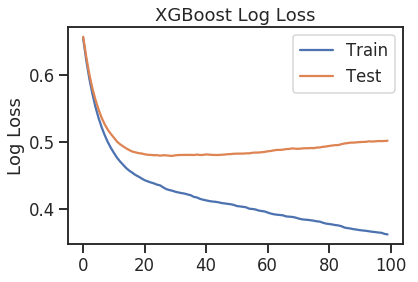

In [17]:
# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()

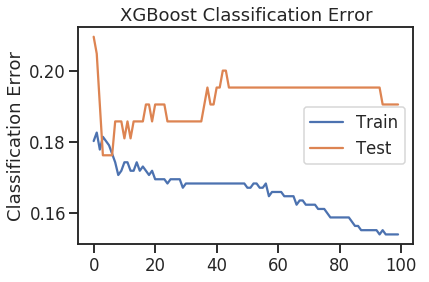

In [18]:
# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()

In [19]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, predictions))


              precision    recall  f1-score   support

           0       0.83      0.97      0.89       173
           1       0.29      0.05      0.09        37

   micro avg       0.81      0.81      0.81       210
   macro avg       0.56      0.51      0.49       210
weighted avg       0.73      0.81      0.75       210



In [20]:
# Save the model
from sklearn.externals import joblib
model_filename = '/usr/local/bin/Gender Prediction/Code/flask/xgboostAPI2.pkl'
print("Saving model to {}...".format(model_filename))
joblib.dump(model, model_filename)

Saving model to /usr/local/bin/Gender Prediction/Code/flask/xgboostAPI2.pkl...


['/usr/local/bin/Gender Prediction/Code/flask/xgboostAPI2.pkl']

In [21]:

joblib_model = joblib.load(model_filename)


# Predict using Fictional browser

In [22]:

    max_len = 27
    
    

In [23]:
# Create your own browser
x_UserId = 'USer ID here' 
x_URL= 'URL NAME' 
x_longDescription = str("URL Description here")
x_DateTime="Time format"

In [24]:
# make a copy of the original data set in order to create dummy categories that are the same as seen on 
# original data
fictional_df = pd.DataFrame([[x_UserId, 
                                     x_URL,x_longDescription,
                                     x_DateTime]], columns = ['UserId','URL', 'long_description', 'DateTime']) 


In [ ]:
print(fictional_df)

In [26]:
def DataprepTest(df):
    
    
    df.dropna(subset=['UserId'],inplace=True)
    df.dropna(subset=['long_description'],inplace=True)
    df.dropna(subset=['DateTime'],inplace=True)

    df['Create Time'] = pd.to_datetime(df['DateTime'])

    # Category Based Features 
    df['URL'].str.strip()
    df['domain'] = df['URL'].str.split('//').str[-1].str.split('/').str[0]
    df['Count'] = df['URL'].str.split('//').str[-1].str.split('/').str.len()
    mask = df['Count'] > 2

    df['Categ'] = np.where(mask,df['URL'].str.split('//').str[-1].str.split('/').str[1], 'No Category')
    df['Subcateg'] = np.where(mask, df['URL'].str.split('//').str[-1].str.split('/').str[2], 'No Subcategory')

    df['Categ'] = df.Categ.astype('category')
    df['Subcateg']= df.Subcateg.astype('category')
    df['domain'] = df.domain.astype('category')
    df1=df[mask]
    # Time n Squential Based
  
    df1["Create Time"]= pd.to_datetime(df1['Create Time'])
    df1['time_hour'] = df1['Create Time'].apply(lambda x: x.hour)

    df2 = df1[df1['long_description'].notna()]

    def sent_to_words(sentences):
        for sent in sentences:
            sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
            sent = re.sub('\s+', ' ', sent)  # remove newline chars
            sent = re.sub("\'", "", sent)  # remove single quotes
            sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
            yield(sent)  
    # Convert to list
    data_ld = df2.long_description.values.tolist()

    data_words = list(sent_to_words(data_ld))
     #Define functions for stopwords, bigrams, trigrams and lemmatization
    def remove_stopwords(texts):
        return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

    def make_bigrams(texts):
        return [bigram_mod[doc] for doc in texts]

    def make_trigrams(texts):
        return [trigram_mod[bigram_mod[doc]] for doc in texts]

    def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
        """https://spacy.io/api/annotation"""
        texts_out = []
        for sent in texts:
            doc = nlp(" ".join(sent)) 
            texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
        return texts_out

    # Build the bigram and trigram models
    bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
    trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

    # Faster way to get a sentence clubbed as a trigram/bigram
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    # Remove Stop Words
    data_words_nostops = remove_stopwords(data_words)

    # Form Bigrams
    data_words_bigrams = make_bigrams(data_words_nostops)

    # Initialize spacy 'en' model, keeping only tagger component (for efficiency)
    # python3 -m spacy download en
    nlp = spacy.load('en', disable=['parser', 'ner'])

    # Do lemmatization keeping only noun, adj, vb, adv
    data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
    # Create Dictionary
    id2word = corpora.Dictionary(data_lemmatized)

    # Create Corpus
    texts = data_lemmatized

    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]
    #For Gibbs sampling using MAllet package...
    mallet_path = '/usr/local/bin//mallet-2.0.8/bin/mallet' # update this path
    ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

    # Build LDA model
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=id2word,
                                               num_topics=20, 
                                               random_state=100,
                                               update_every=1,
                                               chunksize=100,
                                               passes=10,
                                               alpha='auto',
                                               per_word_topics=True)

    def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ld):
        # Init output
        sent_topics_df = pd.DataFrame()

        # Get main topic in each document
        for i, row in enumerate(ldamodel[corpus]):
            row = sorted(row, key=lambda x: (x[1]), reverse=True)
            # Get the Dominant topic, Perc Contribution and Keywords for each document
            for j, (topic_num, prop_topic) in enumerate(row):
                if j == 0:  # => dominant topic
                    wp = ldamodel.show_topic(topic_num)
                    topic_keywords = ", ".join([word for word, prop in wp])
                    sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
                else:
                    break
        sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

        # Add original text to the end of the output
        contents = pd.Series(texts)
        sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
        return(sent_topics_df)

    # Compute Coherence Score
    def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
        """
        Compute c_v coherence for various number of topics
    Parameters:
        ----------
        dictionary : Gensim dictionary
        corpus : Gensim corpus
        texts : List of input texts
        limit : Max num of topics
     Returns:
        -------
        model_list : List of LDA topic models
        coherence_values : Coherence values corresponding to the LDA model with respective number of topics
        """
        coherence_values = []
        model_list = []
        for num_topics in range(start, limit, step):
            model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
            model_list.append(model)
            coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
            coherence_values.append(coherencemodel.get_coherence())

        return model_list, coherence_values
    coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    coherence_ldamallet = coherence_model_ldamallet.get_coherence()
    model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)
    # Select the model and print the topics
    optimal_model = model_list[3]
    model_topics = optimal_model.show_topics(formatted=False)

    df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data_ld )

    # Format
    df_dominant_topic = df_topic_sents_keywords.reset_index()
    df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'long_description']

    df3 = pd.merge(df1, df_dominant_topic, on='long_description')

    params = ["UserId", "Create Time","Categ","time_hour", "URL", "Subcateg", "Topic_Perc_Contrib", "domain"]

    sqFeatures = df3[params]

    from sklearn.preprocessing import LabelEncoder, OneHotEncoder
    cat_columns = [ "Categ","time_hour", "Subcateg", "domain"]
    sqFeatures[cat_columns].apply(lambda col: col.astype('category'))
    # add it to our new dataframe
    label_encoders = {}
    for col in cat_columns:
        print("Encoding {}".format(col))
        new_le = LabelEncoder()
        sqFeatures[col] = pd.factorize(sqFeatures[col])[0]
        sqFeatures[col] = new_le.fit_transform(sqFeatures[col])
        label_encoders[col] = new_le  
    sqFeatures['mutualInfo_re'] = 0

    sqFeatures = sqFeatures.groupby('UserId')[[ "Create Time","Categ","time_hour", "URL", "Subcateg", "Topic_Perc_Contrib", "domain","mutualInfo_re"]].agg(lambda x: x.tolist())
    sqFeatures['domain'] = sqFeatures['domain'].apply(lambda x: np.array(x))
    sqFeatures['Categ'] = sqFeatures['Categ'].apply(lambda x: np.array(x))
    sqFeatures['time_hour'] = sqFeatures['time_hour'].apply(lambda x: np.array(x))
    sqFeatures['Subcateg'] = sqFeatures['Subcateg'].apply(lambda x: np.array(x))
    sqFeatures['Topic_Perc_Contrib'] = sqFeatures['Topic_Perc_Contrib'].apply(lambda x: np.array(x))

    sqFeatures['mutualInfo_re'] = sqFeatures['mutualInfo_re'].apply(lambda x: np.array(x))

    max_len = 27

    sqFeatures['mutualInfo_re'] =sqFeatures['mutualInfo_re'].apply(lambda x: np.pad(x, (0, max_len- 1), 'constant', constant_values=0))
    sqFeatures['Categ'] = sqFeatures['Categ'].apply(lambda x: np.pad(x, (0, max_len - len(x)), 'constant', constant_values=0))
    sqFeatures['domain'] = sqFeatures['domain'].apply(lambda x: np.pad(x, (0, max_len - len(x)), 'constant', constant_values=0))
    sqFeatures['time_hour'] = sqFeatures['time_hour'].apply(lambda x: np.pad(x, (0, max_len - len(x)), 'constant', constant_values=0))        
    sqFeatures['Subcateg'] = sqFeatures['Subcateg'].apply(lambda x: np.pad(x, (0, max_len - len(x)), 'constant', constant_values=0))
    #sqFeatures['mutualInfo_sub'] = sqFeatures['mutualInfo_sub'].apply(lambda x: np.pad(x, (0, max_len - len(x)), 'constant', constant_values=0))
    sqFeatures['Topic_Perc_Contrib'] = sqFeatures['Topic_Perc_Contrib'].apply(lambda x: np.pad(x, (0, max_len - len(x)), 'constant', constant_values=0))
    Features = ["Categ","time_hour", "Subcateg", "Topic_Perc_Contrib", "domain", "mutualInfo_re"]
    sqFeatures['combined'] = sqFeatures[Features].values.tolist()
    #DF = sqFeatures['combined']
  
    
    return sqFeatures

In [27]:
xFict = DataprepTest(fictional_df)



/usr/local/lib/python3.5/dist-packages/gensim/models/wrappers/ldamallet.py:380: RuntimeWarning: invalid value encountered in true_divide
  return topics / topics.sum(axis=1)[:, None]


Encoding Categ
Encoding time_hour


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:175: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Encoding Subcateg
Encoding domain


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [ ]:
print(xFict)

In [29]:
XFict2 = xFict.drop(['Create Time', 'Categ', 'time_hour', 'URL', 'Subcateg', 'Topic_Perc_Contrib', 'domain','mutualInfo_re'], axis = 1) 

In [30]:
map(lambda x : x,XFict2['combined'].iloc[0:1])


In [31]:
series1 = XFict2['combined'].apply(lambda x : np.array(x)).as_matrix().reshape(-1,1)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [ ]:
print(XFict2.shape)
print(series1)

In [33]:
#feature = np.array([e.tolist() for e in series1.flatten()]).reshape(series1.shape[0],series1.shape[1],-1)
features1 = np.apply_along_axis(lambda x : x[0], 1, series1)


In [34]:
nsamples, nx, ny = features1.shape

In [38]:
x1 = features1.reshape(nsamples,nx*ny)

In [39]:
# make predictions for test data
from sklearn.externals import joblib
model_filename = '/usr/local/bin/Gender Prediction/Code/flask/xgboostAPI2.pkl'
model = joblib.load(model_filename)


In [40]:
Y_pred = model.predict_proba(x1)
probability_of_fictional_user = Y_pred[0][1] * 100
print('Probability of you being a Female : %.2f percent' % probability_of_fictional_user)
print(Y_pred)

Probability of you being a Female : 27.70 percent
[[0.72304535 0.27695462]]
